In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from ast import literal_eval

In [2]:
df = pd.read_parquet('/scratch/tsoares/wikidumps/simplewiki-NS0-20230901/val_data/test_data.parquet')
df

,source_title,source_ID,target_title,context,section,mention_present,source_lead,first_version,second_version,direct_match,missing_category,negative_contexts
0,Andouille,18,Taste,Andouille is a type of pork sausage. It is spi...,Lead,True,Andouille is a type of pork sausage. It is spi...,7592354,9074938,True,None,[]
1,Andouille,18,Pecan,Andouille is a type of pork sausage. It is spi...,Lead,True,Andouille is a type of pork sausage. It is spi...,7592354,9074938,True,None,[]
2,Andouille,18,Cane,Andouille is a type of pork sausage. It is spi...,Lead,True,Andouille is a type of pork sausage. It is spi...,7592354,9074938,True,None,[]
3,Astronomy,48,Black_hole,Unsolved problems\nGreat discoveries also prod...,Unsolved problems,True,Astronomy is the scientific study of celestial...,9035453,9035459,True,None,[{'context': 'Astronomy is the scientific stud...
4,Astronomy,48,Dark_matter,Galactic astronomers try to understand the str...,Subfields of astronomy,False,Astronomy is the scientific study of celestial...,9035250,9035453,False,missing_section,[{'context': 'Astronomy is the scientific stud...
...,...,...,...,...,...,...,...,...,...,...,...,...
6238,Aosta_Valley_%28Chamber_of_Deputies_constituen...,1042752,Valle_d%27Aosta,"Aosta Valley (Italian: Valle d'Aosta, French: ...",Lead,False,"Aosta Valley (Italian: Valle d'Aosta, French: ...",9036987,9036989,False,missing_sentence,"[{'context': 'Election results', 'section': 'E..."
6239,Justin_I,1042831,Latin,,Lead,False,,9037540,9037557,False,missing_section,[]
6240,Justin_I,1042831,Medieval_Greek,,Lead,False,,9037540,9037557,False,missing_section,[]
6241,Justin_I,1042831,List_of_Byzantine_emperors,,Lead,False,,9037540,9037557,False,missing_section,[]


In [3]:
print(f"There are {len(df)} links in the test set.")

There are 6243 links in the test set.


In [4]:
print(f"Of these, it was not possible to extract a context from {len(df[df['context'] == ''])} ({len(df[df['context'] == ''])/len(df)*100:.2f}%) links.")
df = df[df['context'] != '']
print(f"We are left with {len(df)} links.")

Of these, it was not possible to extract a context from 602 (9.64%) links.
We are left with 5641 links.


## Plots

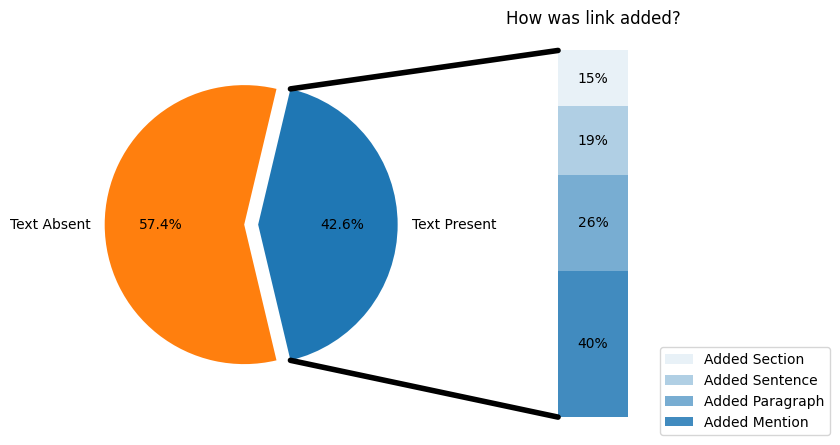

In [23]:
# make figure and assign axis objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
fig.subplots_adjust(wspace=0)

# pie chart parameters
text_present_before = len(df[df['mention_present'] == True]) / len(df)
text_not_present_before = len(df[df['mention_present'] == False]) / len(df)
overall_ratios = [text_present_before, text_not_present_before]
labels = ['Text Present', 'Text Absent']
explode = [0.1, 0]
# rotate so that first wedge is split by the x-axis
angle = -180 * overall_ratios[0]
wedges, *_ = ax1.pie(overall_ratios, autopct='%1.1f%%', startangle=angle,
                     labels=labels, explode=explode)

# bar chart parameters
no_text_df = df[df['mention_present'] == False]
missing_mention = len(no_text_df[no_text_df['missing_category'] == 'missing_mention']) / len(no_text_df)
missing_sentence = len(no_text_df[no_text_df['missing_category'] == 'missing_sentence']) / len(no_text_df)
missing_paragraph = len(no_text_df[no_text_df['missing_category'] == 'missing_paragraph']) / len(no_text_df)
missing_section = len(no_text_df[no_text_df['missing_category'] == 'missing_section']) / len(no_text_df)
no_text_ratios = [missing_mention, missing_sentence, missing_paragraph, missing_section]
no_text_labels = ['Added Mention', 'Added Sentence', 'Added Paragraph', 'Added Section']
# sort ratios and labels jointly by ratios
no_text_ratios, no_text_labels = zip(*sorted(zip(no_text_ratios, no_text_labels), reverse=True))
bottom = 1
width = .2

# Adding from the top matches the legend.
for j, (height, label) in enumerate(reversed([*zip(no_text_ratios, no_text_labels)])):
    bottom -= height
    bc = ax2.bar(0, height, width, bottom=bottom, color='C0', label=label,
                 alpha=0.1 + 0.25 * j)
    ax2.bar_label(bc, labels=[f"{height:.0%}"], label_type='center')

ax2.set_title('How was link added?')
# dont cover bar with legend
ax2.legend(loc='upper right', bbox_to_anchor=(1.2, 0.2))
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)

# use ConnectionPatch to draw lines between the two plots
theta1, theta2 = wedges[0].theta1, wedges[0].theta2
center, r = wedges[0].center, wedges[0].r
bar_height = sum(no_text_ratios)

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(4)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(4)

plt.show()

<Axes: >

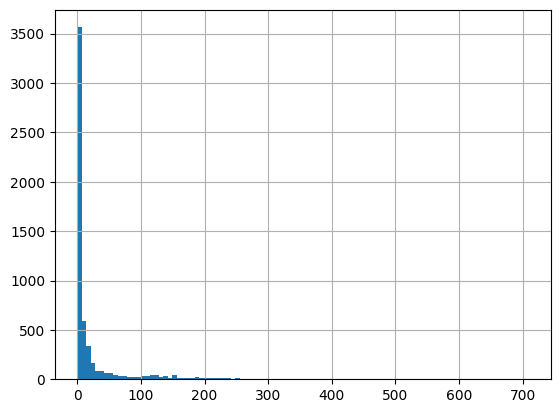

In [34]:
# plot a histogram with the number of negative contexts per link
negative_contexts = df[df['context'] != '']['negative_contexts'].reset_index(drop=True).apply(literal_eval).apply(len)
negative_contexts.hist(bins=100)
# set log x axis
# plt.xscale('log')
# plt.xlabel('Number of negative contexts')
# plt.ylabel('Number of links')
# plt.show()

In [35]:
negative_contexts.describe()

count    5641.000000
mean       24.963482
std        54.052897
min         0.000000
25%         2.000000
50%         4.000000
75%        17.000000
max       709.000000
Name: negative_contexts, dtype: float64